In [43]:
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
np.random.seed(42)

In [44]:
data2 = pd.read_csv('Vowel.csv')
label2 = data2.iloc[:, -1]
data2 = data2.iloc[:, :-1]
for col in data2.columns:
    data2[col] = (data2[col] - data2[col].mean()) / data2[col].std()
dataV = data2.values

def replace_had_with_1(label2):
    mask = (label2 == 'had')
    label2[mask] = 0
    mask = (label2 == 'hAd')
    label2[mask] = 1
    mask = (label2 == 'hed')
    label2[mask] = 2
    mask = (label2 == 'hEd')
    label2[mask] = 3
    mask = (label2 == 'hid')
    label2[mask] = 4
    mask = (label2 == 'hId')
    label2[mask] = 5
    mask = (label2 == 'hod')
    label2[mask] = 6
    mask = (label2 == 'hOd')
    label2[mask] = 7
    mask = (label2 == 'hud')
    label2[mask] = 8
    mask = (label2 == 'hUd')
    label2[mask] = 9
    mask = (label2 == 'hYd')
    label2[mask] = 10

replace_had_with_1(label2)
labelV = label2.values

In [45]:
def initial_center(initial, k):
    return initial[random.sample([i for i in range(initial.shape[0])],k)]
    
def distance(x1, x2):
    return np.linalg.norm(np.array(x1)-np.array(x2))

def k_means(initial, k, error=0.0001, stopping=100):
    initial_centers = initial_center(initial, k)
    for _ in range(stopping):
        clusters = [[] for i in range(k)]
        for point in initial:
            distances = []
            for center in initial_centers:
                distance_value = distance(point, center)
                distances.append(distance_value)
            cluster_index = np.argmin(distances)
            clusters[cluster_index].append(point)
        new_centers = []
        for cluster in clusters:
            center = np.mean(cluster, axis=0)
            new_centers.append(center)
        new_centers = np.array(new_centers)
        if np.all(np.linalg.norm(initial_centers - new_centers, axis=1) < error):
            break
        initial_centers = new_centers
    return initial_centers

In [46]:
def multivariate_normal(x, mean, covariance):
    d = x.shape[0]
    coeff = 1 / np.sqrt((2*np.pi) * np.linalg.det(covariance))
    exp = -0.5 * np.sum((x - mean) @ np.linalg.inv(covariance) * (x - mean), axis=1)
    pdf = coeff * np.exp(exp) 
    return pdf

def gmm(data, k, max_iterations=1000):
    n, d = data.shape
    mu = np.ones(k) / k
    means = initial_center(data, k)
    covariances = []
    for _ in range(k):
        cov = np.eye(d)
        covariances.append(cov)
    def E_step(data, mu, means, covariances):
        post = np.zeros((n, k))
        for i in range(k):
            post[:, i] = mu[i] * multivariate_normal(data, means[i], covariances[i])
        post = post/ np.sum(post, axis=1, keepdims=True)
        return post
    
    def M_step(data, mu, means, covariances, post):
        Nk = np.sum(post, axis=0)
        mu = Nk / n
        means = np.dot(post.T, data) / Nk.reshape(-1,1)
        covariances = []
        for i in range(k):
            covariance = np.dot((data - means[i]).T, (data - means[i]) * post[:, i].reshape(-1,1)) / Nk[i]
            covariances.append(covariance)
        return mu, means, covariances
    
    for _ in range(max_iterations):
        post = E_step(data, mu, means, covariances)
        mu, means, covariances = M_step(data, mu, means, covariances, post)
    labels = np.argmax(post, axis=1)
    return labels, means

In [47]:
def calculate_distance(point1, point2):
    return np.sqrt(np.sum((point1 - point2) ** 2))

def silhouette_coefficient(data, labels):
    n = data.shape[0]
    silhouette_scores = np.zeros(n)
    distances = np.zeros((n, n))
    for i in range(n):
        for j in range(i+1, n):
            distances[i, j] = calculate_distance(data[i], data[j])
            distances[j, i] = distances[i, j]
    for i in range(n):
        label = labels[i]
        label_indices = np.where(labels == label)[0]
        a_i = np.mean(distances[i, label_indices])
        b_distances = []
        for labelb in np.unique(labels):
            if labelb != label:
                labelb_indices = np.where(labels == labelb)[0]
                b_i = np.mean(distances[i, labelb_indices])
                b_distances.append(b_i)
        if len(b_distances)>0:
            b_i = min(b_distances)
            silhouette_scores[i] = (b_i - a_i) / max(a_i, b_i)
    return np.mean(silhouette_scores)

In [48]:
def rand_index(labels_true, labels_pred):
    n = labels_true.shape[0]
    r = 0
    s = 0
    for i in range(n):
        for j in range(i+1, n):
            if labels_true[i] == labels_true[j] and labels_pred[i] == labels_pred[j]:
                r += 1
            elif labels_true[i] != labels_true[j] and labels_pred[i] != labels_pred[j]:
                s += 1
    rand_index = (r + s) / (n * (n - 1) / 2)
    return rand_index

In [49]:
def nmi(labels_true, labels_pred):
    n = labels_true.shape[0]
    clusters = []
    for label in labels_pred:
        if label not in clusters:
            clusters.append(label)
    n_clusters = len(clusters)
    classes = []
    for label in labels_true:
        if label not in classes:
            classes.append(label)
    n_classes = len(classes)
    joint = np.zeros((n_clusters, n_classes))
    labels_pred = labels_pred.astype(int)
    labels_true = labels_true.astype(int)
    for i in range(n):
        joint[clusters.index(labels_pred[i]), classes.index(labels_true[i])] += 1
    mutual = 0
    for i in range(n_clusters):
        for j in range(n_classes):
            pro_xy = joint[i, j] / n
            pro_x = np.sum(joint[i, :]) / n
            pro_y = np.sum(joint[:, j]) / n
            if pro_xy > 0:
                mutual += pro_xy * np.log(pro_xy / (pro_x * pro_y))
            elif pro_x == 0 and pro_y == 0:
                mutual += 0
    h_x = 0
    for i in range(n_clusters):
        pro_x = np.sum(joint[i, :]) / n
        if pro_x > 0:
            h_x += -pro_x * np.log(pro_x)
    h_y = 0
    for j in range(n_classes):
        pro_y = np.sum(joint[:, j]) / n
        if pro_y > 0:
            h_y += -pro_y * np.log(pro_y)
    nmi = mutual / np.sqrt(h_x * h_y)
    return nmi

In [50]:
k_values = [2,3,4,5,6,7,8,9]
silhouette_scores_kmeans = []
silhouette_scores_gmm = []
rand_scores_kmeans = []
rand_scores_gmm = []
for k in k_values:
    k_centers = k_means(dataV, k)
    k_labels = []
    for data in dataV:
        distances = []
        for center in k_centers:
            distance4 = np.linalg.norm(data - center)
            distances.append(distance4)
        cluster_label = np.argmin(distances)
        k_labels.append(cluster_label)
    k_labels = np.array(k_labels)
    gmm_labels, gmm_centers = gmm(dataV, k)
    k_means_silhouette = silhouette_coefficient(dataV, k_labels)
    gmm_silhouette = silhouette_coefficient(dataV, gmm_labels)
    k_means_rand_index = rand_index(labelV, k_labels)
    gmm_rand_index = rand_index(labelV, gmm_labels)
    k_means_nmi = nmi(labelV, k_labels)
    gmm_nmi = nmi(labelV, gmm_labels)
    
    silhouette_scores_kmeans.append(k_means_silhouette)
    silhouette_scores_gmm.append(gmm_silhouette)
    rand_scores_kmeans.append(k_means_rand_index)
    rand_scores_gmm.append(gmm_rand_index)

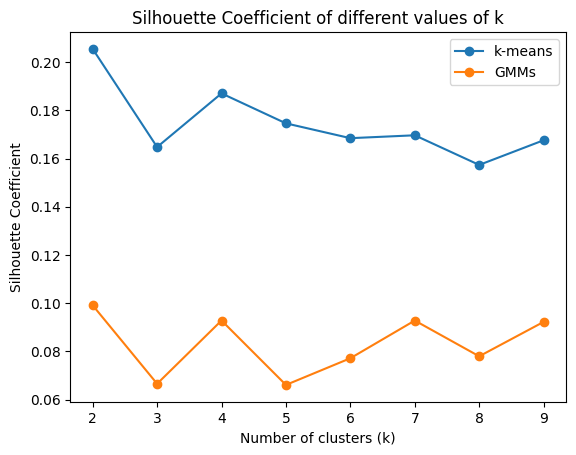

In [51]:
plt.plot(k_values, silhouette_scores_kmeans, marker='o', label='k-means')
plt.plot(k_values, silhouette_scores_gmm, marker='o', label='GMMs')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Silhouette Coefficient')
plt.title('Silhouette Coefficient of different values of k')
plt.legend()
plt.show()

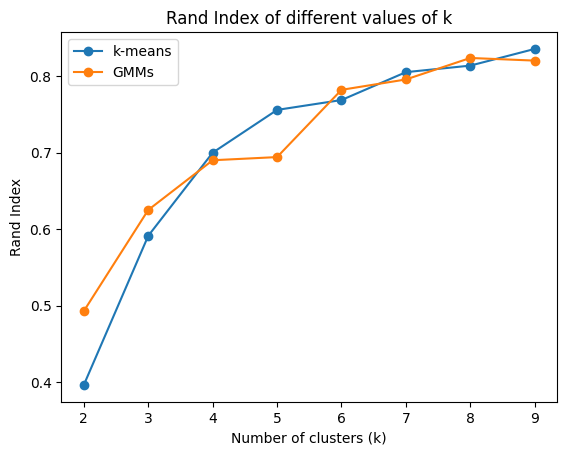

In [52]:
plt.plot(k_values, rand_scores_kmeans, marker='o', label='k-means')
plt.plot(k_values, rand_scores_gmm, marker='o', label='GMMs')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Rand Index')
plt.title('Rand Index of different values of k')
plt.legend()
plt.show()

In [53]:
optimal_k_silhouette = k_values[np.argmax(silhouette_scores_kmeans)]
optimal_k_rand = k_values[np.argmax(rand_scores_kmeans)]

In [54]:
k_centers_silhouette = k_means(dataV, optimal_k_silhouette)
k_labels_silhouette = []
for data in dataV:
    distances = []
    for center in k_centers_silhouette:
        distance2 = np.linalg.norm(data - center)
        distances.append(distance2)
    cluster_label = np.argmin(distances)
    k_labels_silhouette.append(cluster_label)
k_labels_silhouette = np.array(k_labels_silhouette)
nmi_silhouette = nmi(labelV, k_labels_silhouette)

In [55]:
k_centers_rand = k_means(dataV, optimal_k_rand)
k_labels_rand = []
for data in dataV:
    distances = []
    for center in k_centers_rand:
        distance1 = np.linalg.norm(data - center)
        distances.append(distance1)
    cluster_label = np.argmin(distances)
    k_labels_rand.append(cluster_label)
k_labels_rand = np.array(k_labels_rand)
nmi_rand = nmi(labelV, k_labels_rand)

In [56]:
print("Optimal number of clusters based on Silhouette Coefficient (K-means):", optimal_k_silhouette)
print("NMI for the selected k based on Silhouette Coefficient (K-means):", nmi_silhouette)
print("Optimal number of clusters based on Rand Index (K-means):", optimal_k_rand)
print("NMI for the selected k based on Rand Index (K-means):", nmi_rand)

Optimal number of clusters based on Silhouette Coefficient (K-means): 2
NMI for the selected k based on Silhouette Coefficient (K-means): 0.07003683908950908
Optimal number of clusters based on Rand Index (K-means): 9
NMI for the selected k based on Rand Index (K-means): 0.26344007848504053


In [57]:
optimal_g_silhouette = k_values[np.argmax(silhouette_scores_gmm)]
optimal_g_rand = k_values[np.argmax(rand_scores_gmm)]

In [58]:
gmm_labels_silhouette, gmm_centers_silhouette = gmm(dataV, optimal_g_silhouette)
gmm_labels_rand, gmm_centers_rand = gmm(dataV, optimal_g_rand)
nmi_silhouette = nmi(labelV, gmm_labels_silhouette)
nmi_rand = nmi(labelV, gmm_labels_rand)

In [59]:
print("Optimal number of clusters based on Silhouette Coefficient (GMM):", optimal_g_silhouette)
print("NMI for the selected k based on Silhouette Coefficient (GMM):", nmi_silhouette)
print("Optimal number of clusters based on Rand Index (GMM):", optimal_g_rand)
print("NMI for the selected k based on Rand Index (GMM):", nmi_rand)

Optimal number of clusters based on Silhouette Coefficient (GMM): 2
NMI for the selected k based on Silhouette Coefficient (GMM): 0.017892722532953285
Optimal number of clusters based on Rand Index (GMM): 8
NMI for the selected k based on Rand Index (GMM): 0.2253768232650927
